In [364]:
TRAINING_IMAGE_DIR_PATH = '../data/data_object_image_2/training/image_2/'
TRAINING_LABELS_DIR_PATH = '../data/data_object_label_2/training/label_2/'

In [365]:
import os
from typing import Optional, Callable, TypeAlias

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.tv_tensors import BoundingBoxes
from torchvision.transforms import v2 as transforms
from torchvision.utils import draw_bounding_boxes

In [366]:
class_names = (
    'Car',
    'Van',
    'Truck',
    'Pedestrian', 
    'Person_sitting',
    'Cyclist',
    'Tram',
    'Misc',
    'DontCare',
)

In [367]:
DataSample: TypeAlias = tuple[torch.Tensor, dict[str, torch.Tensor]]

In [368]:
class KittiDetectionDataset(Dataset):
    
    def __init__(self,
                 image_dir_path: str,
                 label_dir_path: str,
                 transform: Optional[Callable] = None):
        
        assert os.path.isdir(image_dir_path)
        assert os.path.isdir(label_dir_path)

        self.image_dir_path = image_dir_path
        self.label_dir_path = label_dir_path
        self.transform = transform

        self.n_samples = len(os.listdir(image_dir_path))

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, index: int) -> DataSample:
        filename = f'{index:06d}'

        img = read_image(os.path.join(self.image_dir_path, filename + '.png'))
        labels, boxes = self._read_labels(os.path.join(self.label_dir_path, filename + '.txt'))

        target = {
            'labels': torch.tensor(labels, dtype=torch.int),
            'boxes': BoundingBoxes(boxes, format='XYXY', canvas_size=transforms.functional.get_size(img)),
        }

        if self.transform:
            img = self.transform(img)

        return img, target

    def _read_labels(self, path: str) -> tuple[list[int], list[tuple[float]]]:
        with open(path) as label_file:
            class_labels = []
            boxes = []
            for line in label_file.readlines():
                class_label, bbox = self._parse_object_line(line)
                class_labels.append(class_label)
                boxes.append(bbox)

        return class_labels, boxes

    def _parse_object_line(self, line: str) -> tuple[int, tuple[float]]:
        elements = line.split()

        object_class = class_names.index(elements[0])
        
        left, top, right, bottom = elements[4:8]
        bbox = (left, top, right, bottom)
        bbox = tuple(float(x) for x in bbox)
        
        return object_class, bbox
    

In [369]:
dataset = KittiDetectionDataset(image_dir_path=TRAINING_IMAGE_DIR_PATH, label_dir_path=TRAINING_LABELS_DIR_PATH)

In [370]:
dataset[0]

(tensor([[[17, 16, 25,  ..., 37, 35, 36],
          [17, 14, 24,  ..., 37, 35, 35],
          [17, 18, 18,  ..., 34, 32, 30],
          ...,
          [19, 17, 16,  ..., 24, 20, 20],
          [12, 12, 14,  ..., 20, 21, 21],
          [13, 14, 14,  ..., 22, 22, 20]],
 
         [[22, 24, 29,  ..., 29, 24, 17],
          [19, 23, 28,  ..., 29, 25, 18],
          [16, 16, 21,  ..., 29, 23, 17],
          ...,
          [23, 22, 22,  ..., 25, 26, 27],
          [21, 19, 18,  ..., 25, 25, 27],
          [20, 18, 17,  ..., 30, 29, 30]],
 
         [[18, 28, 33,  ..., 23, 21, 15],
          [16, 20, 24,  ..., 25, 21, 14],
          [16, 19, 21,  ..., 27, 22, 14],
          ...,
          [28, 28, 28,  ..., 32, 32, 31],
          [28, 25, 24,  ..., 33, 32, 30],
          [23, 18, 19,  ..., 37, 38, 35]]], dtype=torch.uint8),
 {'labels': tensor([3], dtype=torch.int32),
  'boxes': BoundingBoxes([[712.4000, 143.0000, 810.7300, 307.9200]], format=BoundingBoxFormat.XYXY, canvas_size=[370, 1224])})

In [371]:
# source: https://pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py

import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(nrows=len(imgs), squeeze=False, figsize=(12, 5))
    #fig.tight_layout()
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[i, 0].imshow(np.asarray(img))
        axs[i, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    plt.show()

def to_image(sample: DataSample):
    img, target = sample
    labels = [ class_names[label.item()] for label in target['labels'] ]
    
    colors = ['blue', 'yellow', 'green', 'red', 'orange'] * 8

    result = draw_bounding_boxes(img, boxes=target['boxes'], labels=labels, colors=colors, width=3)
    return result

In [372]:
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda batch: tuple(batch))

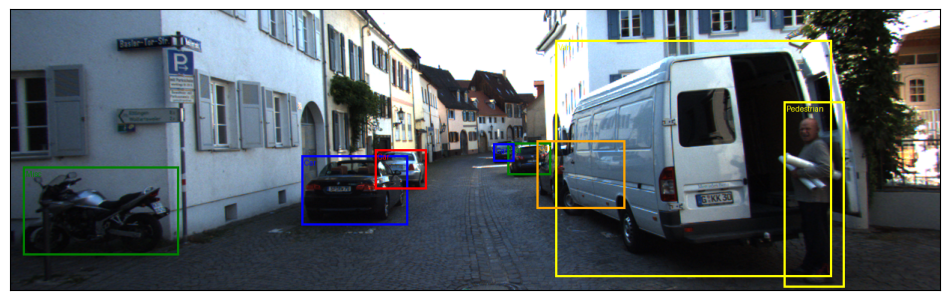

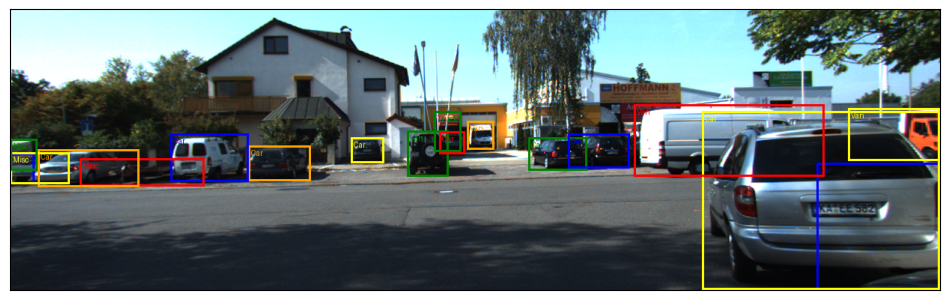

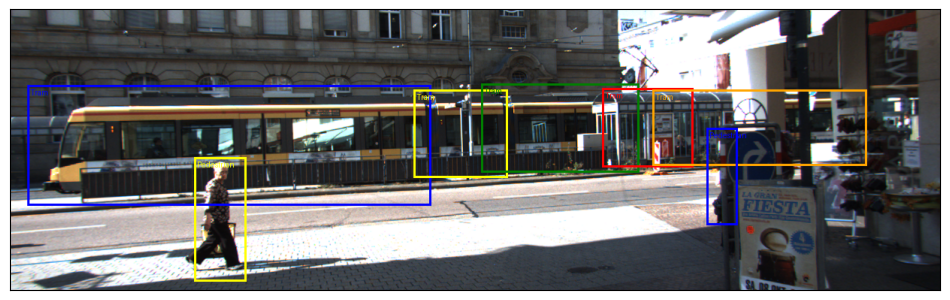

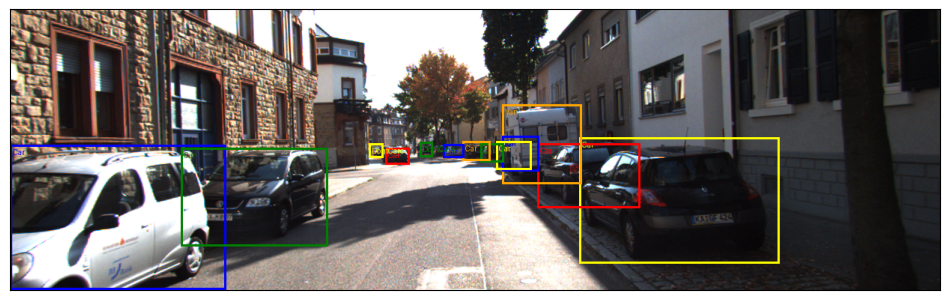

In [373]:
for sample in next(iter(data_loader)):
    show(to_image(sample))
    